In [1]:
# Import necessary libraries and modules for data manipulation, image processing, machine learning, and plotting
import os  # For interacting with the operating system
import numpy as np  # For numerical operations
import cv2  # For image processing tasks
import h5py  # For interacting with HDF5 binary data format
import warnings  # For handling warnings
import matplotlib.pyplot as plt  # For plotting and visualization
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # For data preprocessing
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV  # For model evaluation and selection
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    auc,
    average_precision_score,
    precision_recall_curve
)  # For model performance evaluation
from sklearn.linear_model import LogisticRegression  # Logistic regression classifier
from sklearn.tree import DecisionTreeClassifier  # Decision tree classifier
from sklearn.ensemble import RandomForestClassifier  # Random forest classifier
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # Linear Discriminant Analysis classifier
from sklearn.naive_bayes import GaussianNB  # Gaussian Naive Bayes classifier
from sklearn.svm import SVC  # Support Vector Machine classifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For augmenting image data
import mahotas  # For computer vision and image processing tasks
import seaborn as sns  # For advanced visualization
import pandas as pd  # For data manipulation and analysis
from imblearn.over_sampling import SMOTE  # For handling imbalanced datasets

# Ignore Warnings
warnings.filterwarnings("ignore")  # Suppress warnings to clean up output

In [2]:
# Set tunable parameters for the image processing and classification pipeline
images_per_class = 800  # Define the number of images to use for each class
fixed_size = tuple((500, 500))  # Set a fixed image size for all images to ensure consistency
train_test_path = r"C:\Users\gsanthos\Downloads\Plant-Disease-Detection-master\image_classification\dataset - Copy\train"  # Path to the training dataset
output_dir = r"C:\Users\gsanthos\Downloads\Plant-Disease-Detection-master\image_classification\output"  # Directory to save processed data and outputs
h5_train_data = os.path.join(output_dir, "train_data.h5")  # Path to save the feature vectors (HDF5 format) for training data
h5_train_labels = os.path.join(output_dir, "train_labels.h5")  # Path to save the labels (HDF5 format) for training data
bins = 8  # Number of bins for histogram-based features (e.g., color histogram)
test_size = 0.30  # Proportion of the dataset to be used as test set
seed = 9  # Seed for random operations to ensure reproducibility

In [3]:
# Define a function to convert an image from BGR color space (used by OpenCV) to RGB color space (used by matplotlib and most image display libraries)
def bgr_rgb(image):
    # Use OpenCV's cvtColor function to convert the color space from BGR to RGB
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
# Define a function to convert an image from RGB color space to HSV color space
def rgb_hsv(image):
    # Use OpenCV's cvtColor function to change the color space of the image from RGB to HSV
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

In [5]:
# Define a function for segmenting images to isolate green (healthy) and brown (diseased) areas
def img_segmentation(rgb_img, hsv_img):
    # Define the HSV range for green color (typically representing healthy plant parts)
    lower_green = np.array([25, 0, 20])
    upper_green = np.array([100, 255, 255])
    # Create a mask that isolates the green areas within the specified range
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    # Apply the mask to the original RGB image to extract the green areas
    result = cv2.bitwise_and(rgb_img, rgb_img, mask=healthy_mask)
    
    # Define the HSV range for brown color (typically representing diseased plant parts)
    lower_brown = np.array([10, 0, 10])
    upper_brown = np.array([30, 255, 255])
    # Create a mask that isolates the brown areas within the specified range
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    # Apply the mask to the original RGB image to extract the brown areas
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    
    # Combine the healthy and disease masks to create a final mask
    final_mask = healthy_mask + disease_mask
    # Apply the final mask to the original RGB image to segment out both healthy and diseased areas
    segmented_image = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    
    # Return the segmented image with both green and brown areas isolated
    return segmented_image

In [6]:
# Define a function to extract Hu Moments as a feature descriptor from an image
def fd_hu_moments(image):
    # Convert the image from BGR to grayscale; Hu Moments are calculated on grayscale images
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Calculate the moments of the grayscale image
    moments = cv2.moments(gray_image)
    # Compute Hu Moments from the moments, which are invariant to image transformations such as scaling, rotation, and translation
    feature_vector = cv2.HuMoments(moments).flatten()
    # Return the flattened array of Hu Moments as the feature vector
    return feature_vector

In [7]:
# Define a function to extract Haralick texture features as a feature descriptor from an image
def fd_haralick(image):
    # Convert the input image from BGR color space to grayscale since Haralick texture features are extracted from grayscale images
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute Haralick texture features using the mahotas library, which calculates these features based on the co-occurrence matrix of the grayscale image
    # The mean of the Haralick features is taken across different orientations of the co-occurrence matrix to ensure rotation invariance
    haralick_features = mahotas.features.haralick(gray_image).mean(axis=0)
    
    # Return the computed Haralick texture features as the feature vector
    return haralick_features

In [8]:
# Define a function to extract color histogram features as a feature descriptor from an image
def fd_histogram(image):
    # Convert the input image from BGR color space to HSV color space to capture color information more effectively
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Calculate the color histogram for the HSV image using OpenCV's calcHist function
    # The histogram is calculated for all three channels (Hue, Saturation, Value) with 'bins' number of bins for each channel
    # The histogram range for each channel is set from 0 to 256
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    
    # Normalize the histogram to ensure that the feature vector's magnitude does not affect the classifier's performance
    cv2.normalize(hist, hist)
    
    # Convert the 3D histogram into a 1D array (flattened) to create a feature vector that can be used by machine learning algorithms
    feature_vector = hist.flatten()
    
    # Return the flattened color histogram as the feature vector
    return feature_vector

In [9]:
# Retrieve and organize the training labels from the specified training dataset directory
train_labels = os.listdir(train_test_path)  # List all the directory names in the training dataset path, each representing a label/class
train_labels.sort()  # Sort the labels in alphabetical order to maintain consistency
train_labels.reverse()  # Reverse the sorted list to have it in descending order, if needed for specific ordering requirements
print(train_labels)  # Display the sorted and reversed list of training labels for verification and debugging purposes

['healthy', 'diseased']


In [10]:
# Initialize empty lists for storing extracted feature vectors and corresponding labels of the images
global_features = []  # This list will contain all the feature vectors extracted from the images, where each feature vector represents a set of features describing an image
labels = []  # This list will hold the labels associated with each image, indicating the class/category to which each image belongs

In [11]:
# Iterate through each sub-folder representing a class in the training dataset
for training_name in train_labels:
    # Construct the directory path to the current class's images
    dir = os.path.join(train_test_path, training_name)
    # Set the current class label to the name of the sub-folder
    current_label = training_name

    # Loop through the images in the current class's folder, limited by images_per_class
    for x in range(1, images_per_class + 1):
        # Construct the file path for each image based on its sequence number
        file = dir + "/" + str(x) + ".jpg"

        # Skip processing if the image file does not exist
        if not os.path.exists(file):
            continue

        # Read the image from the file
        image = cv2.imread(file)
        
        # Skip processing if the image is not successfully loaded
        if image is None:
            continue

        # Resize the image to a fixed size to ensure consistency
        image = cv2.resize(image, fixed_size)

        # Preprocess the image by applying various image processing functions
        BGR_RGB = bgr_rgb(image)  # Convert BGR to RGB
        RGB_HSV = rgb_hsv(BGR_RGB)  # Convert RGB to HSV for color segmentation
        IMG_SEGMENT = img_segmentation(BGR_RGB, RGB_HSV)  # Segment the image to isolate relevant features

        # Extract feature vectors from the segmented image using different descriptors
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)  # Hu Moments for shape features
        fv_haralick = fd_haralick(IMG_SEGMENT)  # Haralick texture features
        fv_histogram = fd_histogram(IMG_SEGMENT)  # Color histogram features

        # Combine all feature vectors into a single global feature vector for the image
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # Append the current image's feature vector and label to the global lists
        labels.append(current_label)
        global_features.append(global_feature)

    # Print the status indicating the completion of processing for the current class's folder
    print("[STATUS] processed folder: {}".format(current_label))

[STATUS] processed folder: healthy
[STATUS] processed folder: diseased


In [12]:
print("[STATUS] Completed Global Feature Extraction...")

[STATUS] Completed Global Feature Extraction...


In [13]:
# Get the overall feature vector size
print("[STATUS] Feature Vector Size {}".format(np.array(global_features).shape))

[STATUS] Feature Vector Size (1600, 532)


In [14]:
# get the overall training label size
print("[STATUS] Training Labels {}".format(np.array(labels).shape))

[STATUS] Training Labels (1600,)


In [15]:
# Encode the categorical class labels into numerical values for model training

# Identify and print the unique class labels found in the 'labels' list
targetNames = np.unique(labels)
print(targetNames)

# Initialize a LabelEncoder object from scikit-learn to convert string labels to integers
le = LabelEncoder()

# Fit the label encoder to the class labels and transform them into corresponding integer values
target = le.fit_transform(labels)

# Log the completion status of the label encoding process
print("[STATUS] Training Labels are Encoded...")

['diseased' 'healthy']
[STATUS] Training Labels are Encoded...


In [16]:
# Normalize the extracted feature vectors to have values in the range (0-1)

# Initialize a MinMaxScaler object from scikit-learn to scale features to the specified range
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the global features extracted from the images and transform them to the range (0, 1)
rescaled_features = scaler.fit_transform(global_features)

# Log the completion status of the feature vector normalization process
print("[STATUS] Feature Vector Normalized...")

[STATUS] Feature Vector Normalized...


In [17]:
print("[STATUS] Target Labels Shape: {}".format(target.shape))

[STATUS] Target Labels Shape: (1600,)


In [18]:
# Persist the normalized feature vectors and corresponding labels to disk using the HDF5 format for efficient storage and retrieval

# Open or create an HDF5 file to store the feature vectors and use 'w' to write data
h5f_data = h5py.File(h5_train_data, 'w')
# Create a dataset within the HDF5 file to store the normalized feature vectors, naming it 'dataset_1'
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

# Similarly, open or create another HDF5 file to store the encoded labels
h5f_label = h5py.File(h5_train_labels, 'w')
# Create a dataset within this HDF5 file for the labels, also naming it 'dataset_1'
h5f_label.create_dataset('dataset_1', data=np.array(target))

# Close the HDF5 files to ensure data is written to disk and resources are properly released
h5f_data.close()
h5f_label.close()

In [19]:
# Initialize lists to store the evaluation metrics and curves for each model used in the classification task

model_names = []  # Store the names of the models used for easy identification
training_accuracies = []  # Store the training accuracies of each model
test_accuracies = []  # Store the test accuracies achieved by each model on the unseen data
cv_scores = []  # Store cross-validation scores to assess the models' performance stability across different data splits
f1_scores = []  # Store F1 scores as a balanced measure of precision and recall for each model
precisions = []  # Store precision values to evaluate the models' ability to identify only relevant instances
recalls = []  # Store recall values to assess the models' capability to identify all relevant instances
roc_auc_values = []  # Store the Area Under the Curve (AUC) values from the Receiver Operating Characteristic (ROC) curves as a measure of model discriminability
roc_curves = []  # Store ROC curve data points for plotting and comparison purposes
pr_curves = []  # Store Precision-Recall (PR) curve data points to evaluate the models' performance in the context of class imbalance

In [20]:
# Initialize a list to hold various classification models along with their configurations for comparative analysis

models = []

# Append a tuple containing the model abbreviation and the Logistic Regression model with a fixed random state for reproducibility
models.append(('LR', LogisticRegression(random_state=seed)))

# Append a tuple containing the model abbreviation and the Linear Discriminant Analysis model
models.append(('LDA', LinearDiscriminantAnalysis()))

# Append a tuple containing the model abbreviation and the K-Nearest Neighbors Classifier
models.append(('KNN', KNeighborsClassifier()))

# Append a tuple containing the model abbreviation and the Decision Tree Classifier with a fixed random state for consistent results
models.append(('CART', DecisionTreeClassifier(random_state=seed)))

# Define a parameter grid for the Random Forest Classifier to be used in Grid Search for hyperparameter tuning
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt']}
# Append a tuple containing the model abbreviation and the GridSearchCV object, which encapsulates the Random Forest model with the defined parameter grid and 3-fold cross-validation
models.append(('RF', GridSearchCV(RandomForestClassifier(random_state=seed), rf_param_grid, cv=3)))

# Append a tuple containing the model abbreviation and the Gaussian Naive Bayes model
models.append(('NB', GaussianNB()))

# Append a tuple containing the model abbreviation and the Support Vector Machine classifier with enabled probability estimates and a fixed random state for reproducibility
models.append(('SVM', SVC(probability=True, random_state=seed)))

In [21]:
# Load the previously saved feature vectors and corresponding labels from HDF5 files for model training and evaluation

# Open the HDF5 file containing the saved feature vectors in read-only mode
h5f_data = h5py.File(h5_train_data, 'r')
# Open the HDF5 file containing the saved labels in read-only mode
h5f_label = h5py.File(h5_train_labels, 'r')

# Access the dataset containing the feature vectors and assign it to a variable
global_features_string = h5f_data['dataset_1']
# Access the dataset containing the labels and assign it to a variable
global_labels_string = h5f_label['dataset_1']

# Convert the datasets to numpy arrays for ease of use in model training and evaluation
global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

# Close the HDF5 files to release the resources and ensure data integrity
h5f_data.close()
h5f_label.close()

In [22]:
# verify the shape of the feature vector and labels
print("[STATUS] Features Shape: {}".format(global_features.shape))
print("[STATUS] Labels Shape: {}".format(global_labels.shape))

[STATUS] Features Shape: (1600, 532)
[STATUS] Labels Shape: (1600,)


In [23]:
print("[STATUS] Training Started...")

[STATUS] Training Started...


In [24]:
# Split the dataset into training and testing sets to evaluate the performance of the trained models

# Utilize the train_test_split function from scikit-learn to partition the dataset
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(
    np.array(global_features),  # Feature vectors of the dataset to be split
    np.array(global_labels),  # Corresponding labels of the dataset
    test_size=test_size,  # The proportion of the dataset to include in the test split, defined by the 'test_size' variable
    random_state=seed,  # Seed for the random number generator to ensure reproducible splits
    stratify=np.array(global_labels)  # Data is split in a stratified fashion, using the labels to ensure that both training and testing sets have the same proportion of class labels as the original dataset
)

In [25]:
print("[STATUS] Splitted Train and Test Data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape)) 

[STATUS] Splitted Train and Test Data...
Train data  : (1120, 532)
Test data   : (480, 532)


In [26]:
# Initialize lists to store evaluation results and corresponding model names for later analysis and comparison

results = []  # This list will hold the performance metrics or scores (e.g., accuracy, F1 score) obtained from each model
names = []  # This list will store the names or identifiers of the models tested, corresponding to the entries in the 'results' list

In [27]:
# Iterate through each model defined in the 'models' list to evaluate their performance
for name, model in models:
    
    # Initialize StratifiedKFold to ensure each fold of the cross-validation maintains the proportion of class labels
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    # Perform cross-validation and calculate accuracy scores for each fold to assess the model's stability
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring="accuracy")
    
    # Fit the model to the entire training dataset for further evaluation
    model.fit(trainDataGlobal, trainLabelsGlobal)
    
    # Make predictions on both the training and test datasets to evaluate overfitting and generalization
    y_train_pred = model.predict(trainDataGlobal)
    y_test_pred = model.predict(testDataGlobal)
    # Obtain probability estimates for the test set to calculate ROC AUC and precision-recall metrics
    y_test_proba = model.predict_proba(testDataGlobal)[:, 1]

    # Calculate accuracy on the training set to assess how well the model learned from the data
    training_accuracy = accuracy_score(trainLabelsGlobal, y_train_pred)
    
    # Calculate various performance metrics on the test set to evaluate the model's generalization capability
    test_accuracy = accuracy_score(testLabelsGlobal, y_test_pred)
    f1 = f1_score(testLabelsGlobal, y_test_pred, average='weighted')
    precision = precision_score(testLabelsGlobal, y_test_pred, average='weighted')
    recall = recall_score(testLabelsGlobal, y_test_pred, average='weighted')
    # Compute ROC curve and AUC to assess model's discriminative ability between classes
    fpr, tpr, _ = roc_curve(testLabelsGlobal, y_test_proba)
    roc_auc = auc(fpr, tpr)
    # Compute precision-recall curve and average precision for insights into model performance with respect to class imbalance
    precision_curve, recall_curve, _ = precision_recall_curve(testLabelsGlobal, y_test_proba)
    avg_precision = average_precision_score(testLabelsGlobal, y_test_proba)

    # Append the evaluated metrics and curves to their respective lists for later analysis and comparison
    model_names.append(name)
    training_accuracies.append(training_accuracy)
    test_accuracies.append(test_accuracy)
    cv_scores.append(np.mean(cv_results))
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    roc_auc_values.append(roc_auc)
    roc_curves.append((fpr, tpr))
    pr_curves.append((precision_curve, recall_curve)) 
  

In [28]:
# Construct a DataFrame to consolidate and display the training and testing accuracy for each evaluated model

# Use pandas DataFrame to organize the model names, training accuracies, and testing accuracies into a tabular format
accuracy_data = pd.DataFrame({
    'Model': model_names,  # Column for model names, populated from the 'model_names' list
    'Train Accuracy': training_accuracies,  # Column for training accuracies, populated from the 'training_accuracies' list
    'Test Accuracy': test_accuracies  # Column for testing accuracies, populated from the 'test_accuracies' list
})

# Print the DataFrame to display the accuracies of each model in a clear, tabulated format for easy comparison
print(accuracy_data)

  Model  Train Accuracy  Test Accuracy
0    LR        0.936607       0.900000
1   LDA        0.954464       0.897917
2   KNN        0.954464       0.914583
3  CART        1.000000       0.906250
4    RF        1.000000       0.952083
5    NB        0.871429       0.858333
6   SVM        0.933929       0.902083


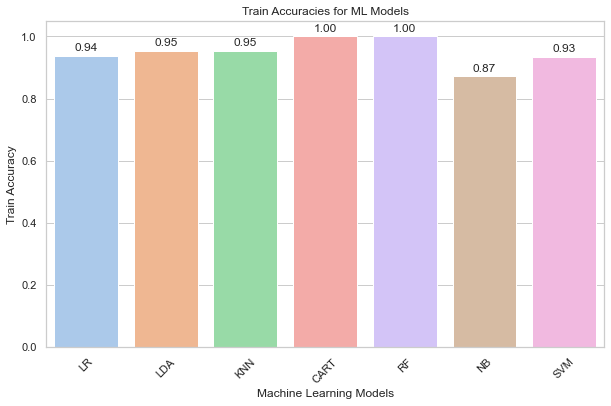

In [29]:
# Generate a bar plot to visually compare the training accuracies of different machine learning models

plt.figure(figsize=(10, 6))  # Set the figure size for the plot
sns.set(style="whitegrid")  # Apply a whitegrid style to the background for better readability
sns.set_palette("pastel")  # Use a pastel color palette for a softer appearance of the bars

# Create a bar plot with 'Model' on the x-axis and 'Train Accuracy' on the y-axis using the accuracy_data DataFrame
bar_plot = sns.barplot(x='Model', y='Train Accuracy', data=accuracy_data)

# Set the x and y-axis labels to provide context to the plot
plt.xlabel('Machine Learning Models')
plt.ylabel('Train Accuracy')

# Set the title of the plot to indicate what the plot represents
plt.title('Train Accuracies for ML Models')

# Rotate the labels on the x-axis by 45 degrees to prevent overlap and improve readability
plt.xticks(rotation=45)

# Loop through each bar in the bar plot to add accuracy labels on top of each bar for precise value representation
for i, v in enumerate(training_accuracies):
    # The text function places a label at the given coordinates; here, it's used to show the accuracy value
    # 'i' is the bar's index, 'v' is the accuracy value, and 'v + 0.01' slightly offsets the label above the bar
    plt.text(i, v + 0.01, "{:.2f}".format(v), ha='center', va='bottom')

plt.show()  # Display the plot

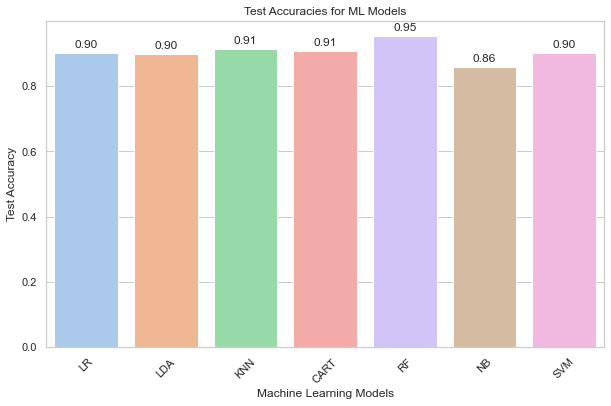

In [30]:
# Generate a bar plot to visually compare the testing accuracies of various machine learning models

plt.figure(figsize=(10, 6))  # Define the dimensions of the plot for clarity and readability
sns.set(style="whitegrid")  # Apply a white grid style to the plot background for a clean look
sns.set_palette("pastel")  # Choose a pastel color palette for a visually appealing plot

# Use seaborn's barplot function to create a bar chart with 'Model' as the x-axis and 'Test Accuracy' as the y-axis
bar_plot = sns.barplot(x='Model', y='Test Accuracy', data=accuracy_data)

# Label the x-axis as 'Machine Learning Models' to indicate the different models compared
plt.xlabel('Machine Learning Models')
# Label the y-axis as 'Test Accuracy' to indicate the metric being compared across models
plt.ylabel('Test Accuracy')

# Set the title of the plot to 'Test Accuracies for ML Models' to describe the plot's purpose
plt.title('Test Accuracies for ML Models')

# Rotate the labels on the x-axis by 45 degrees to ensure they are legible and do not overlap
plt.xticks(rotation=45)

# Loop through each bar in the plot to add an accuracy label at the top for precise value representation
for i, v in enumerate(test_accuracies):
    # Place a text label above each bar displaying the test accuracy rounded to two decimal places
    # The label is positioned at the center ('ha='center'') of the bar and just above the bar ('va='bottom'') with a small offset ('v + 0.01')
    plt.text(i, v + 0.01, "{:.2f}".format(v), ha='center', va='bottom')

plt.show()  # Display the completed bar plot

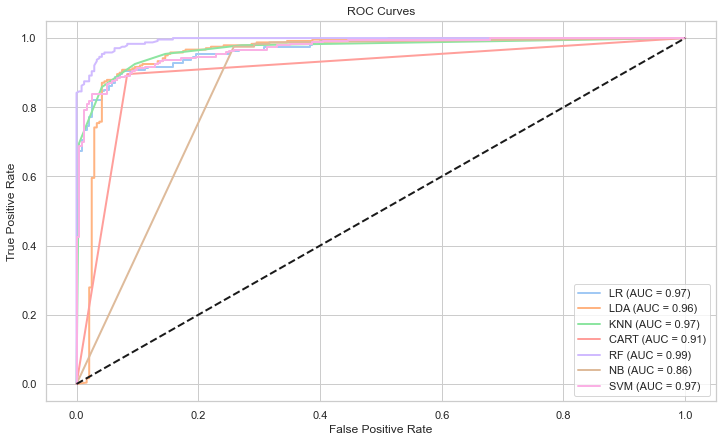

In [31]:
# Generate a plot to visualize the Receiver Operating Characteristic (ROC) curves for all evaluated models

plt.figure(figsize=(12, 7))  # Set the dimensions of the plot for better readability and visual presentation

# Loop through each model along with its ROC curve data (False Positive Rate 'fpr' and True Positive Rate 'tpr')
for i, (name, (fpr, tpr)) in enumerate(zip(model_names, roc_curves)):
    # Plot the ROC curve for each model using its 'fpr' and 'tpr' values
    # Label the curve with the model's name and its Area Under the Curve (AUC) score, formatted to two decimal places
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc_values[i]:.2f})')

# Add a dashed diagonal line (representing a random classifier) for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Label the x-axis as 'False Positive Rate' to represent the proportion of negative instances incorrectly classified as positive
plt.xlabel('False Positive Rate')

# Label the y-axis as 'True Positive Rate' to represent the proportion of positive instances correctly identified
plt.ylabel('True Positive Rate')

# Set the title of the plot to 'ROC Curves' to clearly indicate the plot's purpose
plt.title('ROC Curves')

# Place a legend in the 'lower right' corner of the plot to identify each model's ROC curve
plt.legend(loc="lower right")

# Enable grid lines on the plot to enhance readability and ease of analysis
plt.grid(True)

plt.show()  # Display the plot with ROC curves for all models

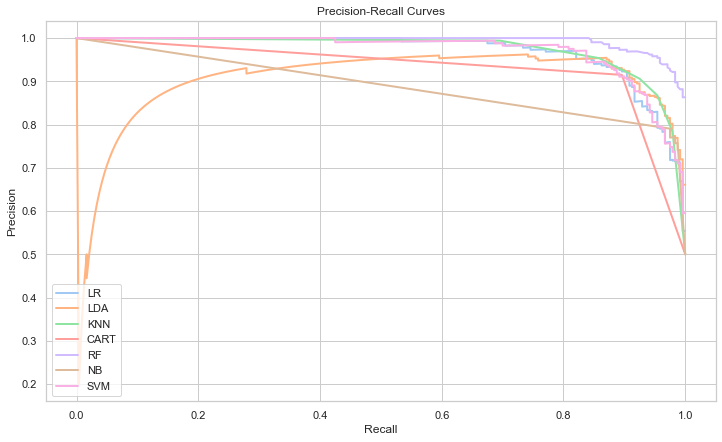

In [32]:
# Generate a plot to visualize Precision-Recall curves for each model to evaluate their performance in terms of precision at various levels of recall

plt.figure(figsize=(12, 7))  # Set the dimensions of the plot to ensure it is large enough for clear visibility of all curves

# Iterate over each model's name and its corresponding Precision-Recall curve data
for name, (precision_curve, recall_curve) in zip(model_names, pr_curves):
    # Plot the Precision-Recall curve for each model
    # The x-axis represents recall, and the y-axis represents precision for each threshold
    plt.plot(recall_curve, precision_curve, lw=2, label=name)

# Label the x-axis as 'Recall' to represent the proportion of actual positives that were correctly identified
plt.xlabel('Recall')

# Label the y-axis as 'Precision' to represent the proportion of positive identifications that were actually correct
plt.ylabel('Precision')

# Set the title of the plot to 'Precision-Recall Curves' to clearly indicate the plot's content
plt.title('Precision-Recall Curves')

# Place a legend in the 'lower left' corner of the plot to identify each model's curve
plt.legend(loc="lower left")

# Enable grid lines on the plot to facilitate easier comparison of curves at different points
plt.grid(True)

plt.show()  # Display the plot with Precision-Recall curves for all evaluated models


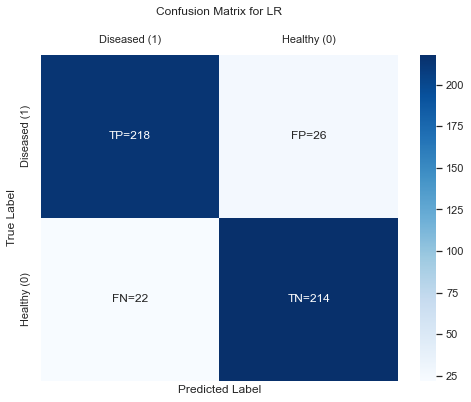

Classification Report for LR:
              precision    recall  f1-score   support

Diseased (1)       0.91      0.89      0.90       240
 Healthy (0)       0.89      0.91      0.90       240

    accuracy                           0.90       480
   macro avg       0.90      0.90      0.90       480
weighted avg       0.90      0.90      0.90       480


Accuracy for LR: 90.00%



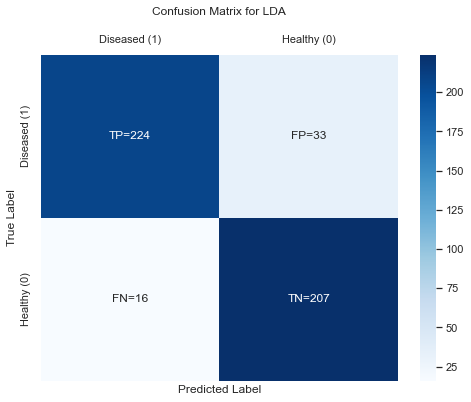

Classification Report for LDA:
              precision    recall  f1-score   support

Diseased (1)       0.93      0.86      0.89       240
 Healthy (0)       0.87      0.93      0.90       240

    accuracy                           0.90       480
   macro avg       0.90      0.90      0.90       480
weighted avg       0.90      0.90      0.90       480


Accuracy for LDA: 89.79%



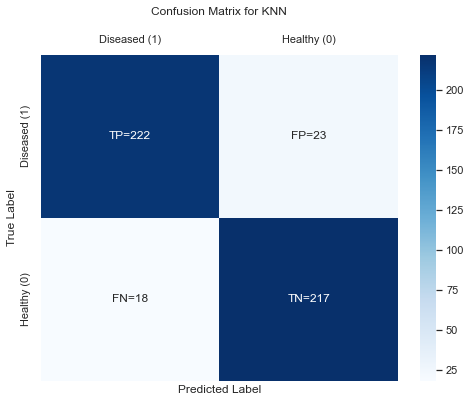

Classification Report for KNN:
              precision    recall  f1-score   support

Diseased (1)       0.92      0.90      0.91       240
 Healthy (0)       0.91      0.93      0.92       240

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.91      0.91      0.91       480


Accuracy for KNN: 91.46%



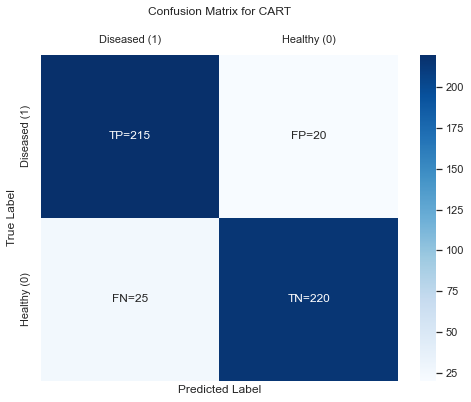

Classification Report for CART:
              precision    recall  f1-score   support

Diseased (1)       0.90      0.92      0.91       240
 Healthy (0)       0.91      0.90      0.91       240

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.91      0.91      0.91       480


Accuracy for CART: 90.62%



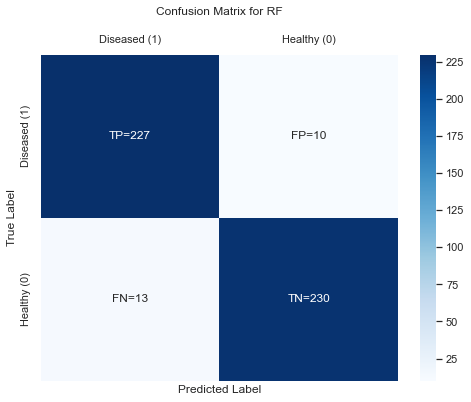

Classification Report for RF:
              precision    recall  f1-score   support

Diseased (1)       0.95      0.96      0.95       240
 Healthy (0)       0.96      0.95      0.95       240

    accuracy                           0.95       480
   macro avg       0.95      0.95      0.95       480
weighted avg       0.95      0.95      0.95       480


Accuracy for RF: 95.21%



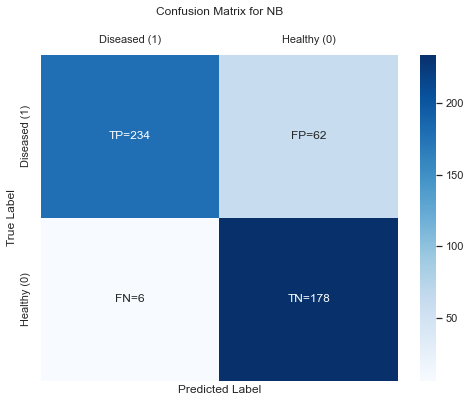

Classification Report for NB:
              precision    recall  f1-score   support

Diseased (1)       0.97      0.74      0.84       240
 Healthy (0)       0.79      0.97      0.87       240

    accuracy                           0.86       480
   macro avg       0.88      0.86      0.86       480
weighted avg       0.88      0.86      0.86       480


Accuracy for NB: 85.83%



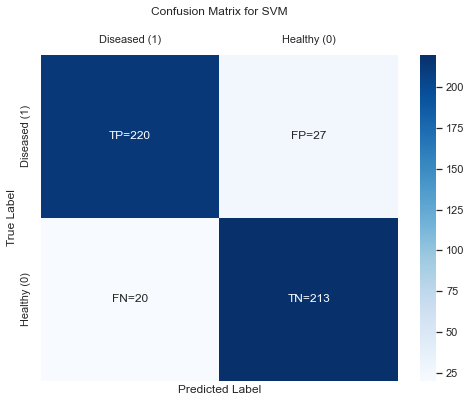

Classification Report for SVM:
              precision    recall  f1-score   support

Diseased (1)       0.91      0.89      0.90       240
 Healthy (0)       0.89      0.92      0.90       240

    accuracy                           0.90       480
   macro avg       0.90      0.90      0.90       480
weighted avg       0.90      0.90      0.90       480


Accuracy for SVM: 90.21%



In [33]:
# Visualize the confusion matrix as a heatmap and display the classification report for each evaluated model

class_names = ['Diseased (1)', 'Healthy (0)']  # Define class names for clearer interpretation in the plots and reports

# Iterate through each model to evaluate its performance on the test set
for name, model in models:
    # Train the model on the training dataset
    model.fit(trainDataGlobal, trainLabelsGlobal)
    # Use the trained model to make predictions on the test dataset
    y_test_pred = model.predict(testDataGlobal)
        
    # Calculate the confusion matrix to evaluate the model's performance
    cm = confusion_matrix(testLabelsGlobal, y_test_pred)
        
    # Prepare annotation labels for the confusion matrix heatmap, indicating True Positives (TP), False Positives (FP),
    # False Negatives (FN), and True Negatives (TN)
    cm_labels = np.array([['TP={}'.format(cm[1, 1]), 'FP={}'.format(cm[0, 1])], 
                          ['FN={}'.format(cm[1, 0]), 'TN={}'.format(cm[0, 0])]])
        
    plt.figure(figsize=(8, 6))  # Set the size of the figure for the heatmap
    
    # Create a heatmap visualization of the confusion matrix using seaborn, with annotated labels
    sns.heatmap(cm, annot=cm_labels, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    
    # Adjust the x-axis labels to appear on the top of the heatmap for better readability
    plt.tick_params(axis='x', labelrotation=0, labeltop=True, labelbottom=False)
    
    # Label the x-axis as 'Predicted Label' and the y-axis as 'True Label'
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # Set the title to indicate which model's confusion matrix is being displayed
    plt.title(f'Confusion Matrix for {name}', pad=20)
    plt.show()  # Display the heatmap
    
    # Generate and print the classification report, providing detailed performance metrics such as precision, recall, and F1-score
    cr = classification_report(testLabelsGlobal, y_test_pred, target_names=class_names)
    print(f"Classification Report for {name}:\n{cr}\n")

    # Calculate and print the accuracy score to assess the overall performance of the model
    accuracy = accuracy_score(testLabelsGlobal, y_test_pred)
    print(f"Accuracy for {name}: {accuracy * 100:.2f}%\n")

In [34]:
# Identify and display the model with the highest accuracy on the test dataset from the evaluated models

# Use np.argmax to find the index of the maximum test accuracy in the list of test accuracies
max_accuracy_index = np.argmax(test_accuracies)

# Retrieve the name of the best performing model using the index obtained above
best_model_name = model_names[max_accuracy_index]

# Retrieve the highest test accuracy value using the same index
best_model_accuracy = test_accuracies[max_accuracy_index]

# Print out the best model's name and its test accuracy, formatted as a percentage and rounded to two decimal places
print(f"The best model out of all the evaluated modles is '{best_model_name}' with a test accuracy of {best_model_accuracy * 100:.2f}%.")

The best model out of all the evaluated modles is 'RF' with a test accuracy of 95.21%.
